In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.6.0


In [3]:
# Load data
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [4]:
# Map sentiments to 3 classes
label_map = {
    "Mild_Pos": "positive", "Strong_Pos": "positive",
    "Mild_Neg": "negative", "Strong_Neg": "negative",
    "Neutral": "neutral"
}
train_df["sentiment_label"] = train_df["sentiment_label"].map(label_map)
test_df["sentiment_label"] = test_df["sentiment_label"].map(label_map)

In [5]:
# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["processed_tweet"])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df["processed_tweet"]), maxlen=maxlen)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df["processed_tweet"]), maxlen=maxlen)

In [6]:
# Reshape for GRU layer (add channel dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
# 3. Encode labels
y_encoder = LabelEncoder()
y_train = y_encoder.fit_transform(train_df["sentiment_label"])  # Integer labels
y_test = y_encoder.transform(test_df["sentiment_label"])
class_names = y_encoder.classes_

In [10]:
# Compute class weights
#class_weights = compute_class_weight(
 #   class_weight='balanced',
  #  classes=np.unique(y_train_int),
   # y=y_train_int
#)3
#class_weights = dict(enumerate(class_weights))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('Bidirectional GRU.h5')

In [9]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) 
print("X_test shape:", X_test.shape)
y_train = y_train.reshape((X_train.shape[0], -1))
print("y_train shape:", y_train.shape)
y_test = y_test.reshape((X_test.shape[0], -1))
print("y_test shape:", y_test.shape)

X_test shape: (90263, 100, 1)
y_train shape: (361051, 1)
y_test shape: (90263, 1)


In [10]:
from keras.utils import to_categorical

# Check the shape
print("y_train shape before:", y_train.shape)

# Only apply to_categorical if y_train is 1D
if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=3)
    y_test = to_categorical(y_test, num_classes=3)
else:
    print("Skipping to_categorical - y_train already one-hot or malformed.")

y_train shape before: (361051, 1)
Skipping to_categorical - y_train already one-hot or malformed.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)) 

# Preprocess labels (assuming integer-encoded labels initially)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Model builder with tunable hyperparameters
def build_model(units=64, dropout=0.3, learning_rate=0.001, reg_factor=0.01, input_shape=None):
    model = Sequential()
    model.add(Bidirectional(
        GRU(units, return_sequences=False, kernel_regularizer=l2(reg_factor)),
        input_shape=input_shape
    ))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))  # multi-class classification
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Round 1 Tuning
print("Tuning Round 1")
model1 = build_model(
    units=64,
    dropout=0.3,
    learning_rate=0.001,
    reg_factor=0.01,
    input_shape=(X_train.shape[1], X_train.shape[2])
)
model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Round 2 Tuning
print("\nTuning Round 2")
model2 = build_model(
    units=128,
    dropout=0.5,
    learning_rate=0.0005,
    reg_factor=0.001,
    input_shape=(X_train.shape[1], X_train.shape[2])
)

model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Tuning Round 1


C:\Users\ammav\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1276s 111ms/step - accuracy: 0.6856 - loss: 0.7904 - val_accuracy: 0.7020 - val_loss: 0.7631
Epoch 2/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1106s 98ms/step - accuracy: 0.7037 - loss: 0.7480 - val_accuracy: 0.7057 - val_loss: 0.7625
Epoch 3/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1018s 90ms/step - accuracy: 0.7054 - loss: 0.7461 - val_accuracy: 0.7047 - val_loss: 0.7530
Epoch 4/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1041s 92ms/step - accuracy: 0.7071 - loss: 0.7409 - val_accuracy: 0.7028 - val_loss: 0.7721
Epoch 5/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1036s 92ms/step - accuracy: 0.7055 - loss: 0.7433 - val_accuracy: 0.7038 - val_loss: 0.7536

Tuning Round 2
Epoch 1/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1028s 91ms/step - accuracy: 0.7054 - loss: 0.7441 - val_accuracy: 0.6982 - val_loss: 0.7689
Epoch 2/5
11283/11283 ━━━━━━━━━━━━━━━━━━━━ 1031s 91ms/step - accuracy: 0.7072 - loss: 0.7415 - val_accuracy: 0.7053 - val_loss: 0.7567
Epoch 3/5
11283/11283 ━━━━━━━━━━━━━━━━

In [12]:
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)

11283/11283 ━━━━━━━━━━━━━━━━━━━━ 317s 28ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step 


In [13]:
train_pred = np.argmax(train_predict, axis=1)
test_pred = np.argmax(test_predict, axis=1)

y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

train_acc = accuracy_score(y_train_true, train_pred)
test_acc = accuracy_score(y_test_true, test_pred)

In [14]:
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.7110
Test Accuracy: 0.7033


11283/11283 ━━━━━━━━━━━━━━━━━━━━ 320s 28ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step 
Train F1 Scores:
              precision    recall  f1-score   support

    negative       0.49      0.20      0.28     61290
     neutral       0.54      0.38      0.45     61598
    positive       0.75      0.93      0.83    238163

    accuracy                           0.71    361051
   macro avg       0.60      0.50      0.52    361051
weighted avg       0.67      0.71      0.67    361051


Test F1 Scores:
              precision    recall  f1-score   support

    negative       0.50      0.17      0.25     15322
     neutral       0.54      0.31      0.40     15400
    positive       0.74      0.94      0.83     59541

    accuracy                           0.70     90263
   macro avg       0.59      0.48      0.49     90263
weighted avg       0.66      0.70      0.66     90263



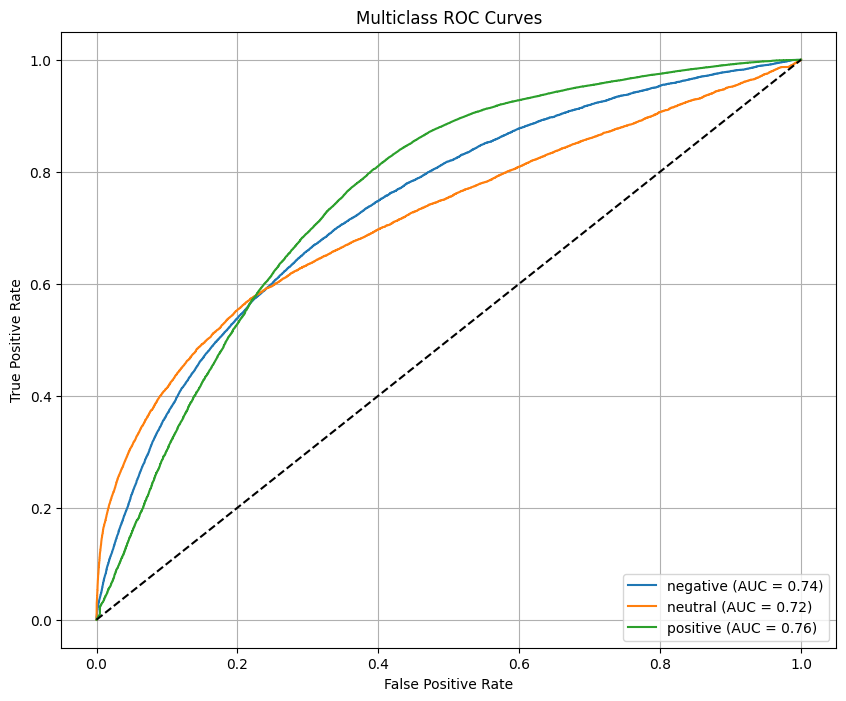

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report
import numpy as np

# 1. Get predictions (probabilities and class labels)
y_train_pred_probs = model1.predict(X_train)  # Probabilities for each class
y_test_pred_probs = model1.predict(X_test)
y_train_pred_labels = np.argmax(y_train_pred_probs, axis=1)  # Predicted class indices
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)

# 2. Get true labels (convert from one-hot if needed)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# 3. Calculate F1 scores
print("Train F1 Scores:")
print(classification_report(y_train_true, y_train_pred_labels, target_names=class_names))

print("\nTest F1 Scores:")
print(classification_report(y_test_true, y_test_pred_labels, target_names=class_names))

# 4. ROC Curve and AUC (for each class)
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    # Calculate ROC curve for each class (one-vs-rest)
    fpr, tpr, _ = roc_curve(y_test_true == i, y_test_pred_probs[:, i])
    auc_score = roc_auc_score(y_test_true == i, y_test_pred_probs[:, i])
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()
